# [Target Network + DDQN] Main Training

In [1]:
import pandas as pd
import numpy as np
import itertools
from tqdm.notebook import tqdm
import pickle

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.utils.data.sampler as sampler
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from collections import defaultdict
import warnings
from sklearn.preprocessing import LabelEncoder
import random
from datetime import datetime
import pytz
import line_profiler

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Fix Random Seeds

In [2]:
def same_seeds(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
  np.random.seed(seed)  
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

same_seeds(0)

## Prepare Data

In [3]:
CONTEXT_REPS = pd.read_pickle('../../data/w_final_context.pkl')
STREAM_ITEM_DICT = pd.read_pickle('../../data/stream_item_dict.pkl')
BERT_BY_IDX_DF = pd.read_pickle('../../data/bert_by_idx_pca.pkl')
BOUGHT_DICT = pd.read_pickle('../../data/bought_dict.pkl')
USER_ALL_STREAM_INIT = CONTEXT_REPS.describe().loc['50%']

In [4]:
CONTEXT_REPS.shape, len(STREAM_ITEM_DICT), BERT_BY_IDX_DF.shape, len(BOUGHT_DICT)

((1397141, 219), 7701, (162189, 160), 79207)

In [5]:
USER_LIST = CONTEXT_REPS.index.get_level_values('asid').tolist()

In [6]:
LB_ITEMS = ['item_id'] + [f'i{x}' for x in range(160)]
INPUT_DF_COL__USR = CONTEXT_REPS.columns.to_list()
INPUT_DF_COL = INPUT_DF_COL__USR + LB_ITEMS

'''
METHOD FOR BOTH EXP_REPLAY & DQN
Convert state format to model input format
'''
def get_input_tensor(input_state, current_stream, with_tensor=False):
  # Get item feats
  # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})

  # Fill in other context
  stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
  
  # Merge with items
  stream_item_feat = stream_item_feat.merge(item_feat, left_index=True, right_index=True).astype('float32')
  
  # Convert to tensor
  if with_tensor: 
    stream_item_feat_tensor = df_to_tensor(stream_item_feat)
    return stream_item_feat_tensor, stream_item_feat
  else:
    return stream_item_feat

In [7]:
'''
METHOD FOR BOTH EXP_REPLAY & DQN

Generate series: whether elements in A existed in list B
A, B: List
return: pd.Series
example:
  A: [1, 2, 4, 5]
  B: [1, 2, 3, 4, 5, 6, 7]
  return: Series([1, 1, 0, 1, 1, 0, 0], index=[1, 2, 3, 4, 5, 6, 7])
'''
def gen_exist_series(A, B):
  return [int(item in A) for item in B]

In [8]:
def df_to_tensor(input_df):
  return torch.tensor(input_df.values).to(DEVICE).float()

## Replay

In [9]:
class ReplayBuffer:
  def __init__(self, max_memory=100000, discount=.9, model_output_shape=1):
    """
    Setup
    max_memory: the maximum number of experiences we want to store
    memory: a list of experiences
    discount: the discount factor for future experience
    In the memory the information whether the game ended at the state is stored seperately in a nested array
    [...
    [experience, game_over]
    [experience, game_over]
    ...]
    """
    self.max_memory = max_memory
    self.memory = list()
    self.discount = discount
    self.model_output_shape = model_output_shape

  def remember(self, states, game_over):
    # Save a state to memory
    self.memory.append([states, game_over])
    # We don't want to store infinite memories, so if we have too many, we just delete the oldest one
    if len(self.memory) > self.max_memory:
      del self.memory[0]

  def get_batch(self, eval_net, target_net, batch_size=10):
    # How many experiences do we have?
    len_memory = len(self.memory)

    # Calculate the number of actions that can possibly be taken in the game.
    # Actions: 0 = not recommend, 1 = recommend
    num_actions = self.model_output_shape

    # Dimensions of our observed states, ie, the input to our model.
    # Memory:  [
    #   [ [ [stream, next_stream], [...state], action, reward, next_state_idx], game_over],
    #   [ [ [stream, next_stream], [...state], action, reward, nexr_state_idx], game_over],
    #   ...
    # ]
    env_dim = len(INPUT_DF_COL)

    inputs = pd.DataFrame()
    targets = torch.tensor([], dtype=torch.float32).to(DEVICE)
    
    
    # We draw states to learn from randomly
    for i, idx in enumerate(np.random.randint(0, len_memory, size=min(len_memory, batch_size))):  
      # Here we load one transition <s, a, r, s'> from memory
      streams, state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
      current_stream, next_stream = streams
      game_over = self.memory[idx][1]

      '''
      修改倒入 state 的方式 input = (state - item) + item_feat
      拆掉 model_predict 成 function
      
      here should be state_t * all_items
      '''
      state_tensor, state_t = get_input_tensor(state_t, current_stream, with_tensor=True)
      # puts state into input
      inputs = pd.concat([inputs, state_t], axis=0)
      
      # use target_net to predict target for eval_net to learn
      current_target = target_net(state_tensor).detach().view(len(reward_t), 1)

      selected_ids = np.where(action_t > 0)[0]
      reward_t = df_to_tensor(reward_t).view(len(reward_t), 1)
      
      '''
      每個 actions 都會被 predict 一個成績/reward
      '''
      # if the game ended, the reward is the final reward
      if game_over:  # if game_over is True
        current_target[selected_ids] = reward_t[selected_ids]
      else:
        # DIFF btw current_stream & next_stream
        state_tp1, _ = get_input_tensor(state_tp1, next_stream, with_tensor=True)
        # Double DQN
        _, selected_actions = eval_net(state_tp1).max(dim=0, keepdim=True)
        Q_sa = target_net(state_tp1).gather(dim=0, index=selected_actions)

        # r + gamma * max Q(s',a')
        # current_target = reward_t + self.discount * Q_sa
        current_target[selected_ids] = reward_t[selected_ids] + Q_sa * self.discount
        
      targets = torch.cat((targets, current_target), 0)
    return inputs, targets

## Epsilon

In [10]:
from abc import ABC, abstractmethod
import math

class Epsilon(ABC):
  @abstractmethod
  def clear(self):
    pass
  
  @abstractmethod
  def get_epsilon(self, key):
    pass
  
  @abstractmethod
  def update_at_step(self, key, data):
    pass
  
  @abstractmethod
  def update_at_epoch(self, data):
    pass
  
  # @abstractmethod
  # def update_at_epsisode():
  #   pass


class Decay(Epsilon):
  # Ref: Decay(0.5, 0.85)
  '''
  Epsilon Decay EE method with update/decay at epoch
  '''
  def __init__(self, initial, epoch_decay, step_decay):
    self.initial = initial
    self.epoch_decay, self.step_decay = epoch_decay, step_decay
    self.epsilon = self.initial
    
  def clear(self):
    self.epsilon = self.initial # should be 4 for origin setting
    
  def get_epsilon(self, key):
    return self.epsilon
  
  def update_at_step(self, key, data):
    # origin setting
    pass
    # exponentially
    # self.epsilon *= self.step_decay
    
  def update_at_epoch(self, data):
    # origin settings
    epoch = data
    self.epsilon = 4 / ((epoch + 1) ** (1 / 2))
    # exponentially
    # self.epsilon *= self.epoch_decay


class VDBE(Epsilon):
  # VDBE(0.5, 0.01)
  def __init__(self, initial, sigma):
    self.initial = initial
    self.sigma = sigma

  def clear(self):
    self.epsilon = defaultdict(lambda: self.initial)

  def get_epsilon(self, key):
    return self.epsilon[key]
  
  def update_at_step(self, key, data, delta):
    td_error = data
    coeff = math.exp(-abs(td_error) / self.sigma)
    f = (1.0 - coeff) / (1.0 + coeff)
    self.epsilon[key] = delta * f + (1.0 - delta) * self.epsilon[key]
  
  def update_at_epoch(self, data):
    pass

## DQN

In [11]:
class DQN(object):
  def __init__(self, exp_replay, epsilon, num_episode, epochs, batch_size, lr, switch_param_threshold):
    self.eval_net, self.target_net = Net(), Net()
    self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=lr)
    self.loss_fn = nn.MSELoss()
    self.exp_replay = exp_replay
    self.epsilon = epsilon
    self.num_episode = num_episode
    self.epochs = epochs
    self.batch_size = batch_size
    self.switch_param_threshold = switch_param_threshold
    self.user_all_stream_init = USER_ALL_STREAM_INIT
    self.hist = []
    self.c_hist = []
    self.rec_list = []
    self.ep_score_list = []
    self.learn_step_counter = 0

  # Environment Methods
  def __episodes(self):
    # return USER_LIST[:self.num_episode]
    return np.random.choice(USER_LIST, self.num_episode, replace=False)
  
  def __user_episode_context(self):
    self.user_all_streams = CONTEXT_REPS.xs(self.asid, level="asid")
    self.stream_list = self.user_all_streams.index
    self.final_stream = max(self.stream_list)
  
  def __full_state(self, i):
    '''
    retrieve full state -> should be exported to pickle
    '''
    if (i - 1) == -1:
      user_part = self.user_all_stream_init.copy()
      user_part.name = self.stream_list[i]
    else:
      user_part = self.user_all_streams.loc[self.stream_list[(i - 1)]]
    return user_part

  def reward(self):
    '''
    Comparison function for reward, 考慮「所有」歷史購買紀錄
    '''
    real_bought_ids = BOUGHT_DICT[self.asid]
    real_bought_ids_series = gen_exist_series(real_bought_ids, self.stream_items)
    
    reward_list = [a & b for a, b in zip(real_bought_ids_series, self.action_ids)]
    # Reward Count 
    self.rec_cnt += 1
    if sum(reward_list) > 0:
      self.c_win_cnt += 1
      self.win_cnt += 1
      self.ep_score += sum(reward_list)
    # return list(map(lambda x: x * sum(reward_list), reward_list))
    return pd.Series(list(map(lambda x: x * sum(reward_list), reward_list)), index=self.stream_items)

  # Agent Methods
  def __choose_actions(self):
    if np.random.rand() <= self.epsilon.get_epsilon(self.asid):
    # if len(self.exp_replay.memory) < 1:
      # Explore by randomly select 10/n items from candidate_items
      # Get all items from the stream
      self.explore += 1
      selected_actions = random.sample(self.stream_items, 10) if len(self.stream_items) > 10 else self.stream_items
    else:
      # Exploit by choosing action from the model's prediction
      self.exploit += 1
      selected_actions = self.__agent_predict()
    x = pd.Series(0, index=self.stream_items)
    x.loc[selected_actions] = 1
    return x
    
  def q_value(self): 
    if type(self.epsilon) == Decay: return 0

    predicts = self.eval_net(self.full_input).flatten()    
    actions_idx = np.where(self.action_ids.values == 1)[0]
    q_val = predicts[actions_idx].mean()
    return q_val

  def __agent_predict(self):
    predicts = self.eval_net(self.full_input).flatten()
    if len(predicts) > 10:
      top10_idx = torch.topk(predicts, 10).indices.cpu()
      actions = self.candidate_actions.iloc[top10_idx]['item_id'].values
    else:
      actions = self.candidate_actions['item_id'].values
    return actions

  def __train_agent_batch(self, inputs, targets):
    self.optimizer.zero_grad()
    outputs = self.eval_net(inputs)
    loss = self.loss_fn(outputs, targets)
    # Add CL Regularization Term
    loss.backward()
    self.optimizer.step()
    return loss.item()

  # MAIN TRAIN
  def train(self):
    self.eval_net.to(DEVICE)
    self.target_net.to(DEVICE)
    self.c_win_cnt = 0
    self.eval_net.train(True)
    self.epsilon.clear()
    self.explore = 0
    self.exploit = 0

    for e in self.epochs:
      self.rec_cnt = 0
      self.win_cnt = 0
      self.loss = 0.
      self.ep_score = 0

      print(f'Epoch {e} started.   Time: {datetime.now(pytz.timezone("Asia/Taipei")).strftime("%H:%M:%S")}')
      # ------------------- Episode (User) -------------------------------
      for asid in tqdm(self.__episodes()):
        self.asid = asid
        self.__user_episode_context()

        # ----------------- Runs (User x All_Stream) ---------------------
        for i, stream in enumerate(self.stream_list):
          game_over = stream == self.final_stream
          self.current_stream = stream
          self.current_state = self.__full_state(i)
          self.stream_items = STREAM_ITEM_DICT[self.current_stream]
          self.full_input, self.candidate_actions = get_input_tensor(self.current_state, self.current_stream, with_tensor=True)

          # --------------- Explore/Exploit Section ----------------------
          self.action_ids = self.__choose_actions()

          # --------------- Get next state & info to store ---------------
          reward = self.reward()
          next_state = self.__full_state(i+1) if not game_over else []
          next_stream = 0 if (i + 1) == len(self.stream_list) else self.stream_list[i + 1]
          self.exp_replay.remember([[stream, next_stream], self.current_state, self.action_ids, reward, next_state], game_over)
          self.learn_step_counter += 1
          if self.learn_step_counter % self.switch_param_threshold == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())


          # --------------- Load batch of experiences --------------------
          inputs, targets = self.exp_replay.get_batch(self.eval_net, self.target_net, batch_size=self.batch_size)
          inputs = df_to_tensor(inputs)
          # store pre-training value for td_error
          old_Q = self.q_value()
          batch_loss = self.__train_agent_batch(inputs, targets)
          # store post-training value for td_error
          new_Q = self.q_value()
          self.loss += batch_loss

          # --------------- Update with TD error -------------------------
          self.epsilon.update_at_step(self.asid, (new_Q - old_Q), len(self.stream_items))

      # Track win history to later check if our model is improving at the game over time.
      self.hist.append(self.win_cnt)
      self.c_hist.append(self.c_win_cnt)
      self.rec_list.append(self.rec_cnt)
      self.ep_score_list.append(self.ep_score)

      print(f'Epoch: {e}/{len(self.epochs)} | Loss {self.loss} | Epoch Hit Rate {self.win_cnt/self.rec_cnt} | \
              Cumulative Hit Rate {self.c_win_cnt/sum(self.rec_list)} | Explore {self.explore} | Exploit {self.exploit} | \
              Score {self.ep_score}')

## Main Method

In [12]:
pd.set_option('mode.chained_assignment', None)

# parameters
MAX_MEMORY = 1000  # Maximum number of experiences we are storing
BATCH_SIZE = 2  # Number of experiences we use for training per batch
EPOCH = range(100)
TOTAL_ACTIONS = 1 # probability of ordering
NUM_EPISODE = 100
HIDDEN_SIZE = 512
LR = 1.0e-4
SWITCH_PARAM_THRESHOLD = 100

warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(380, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 1)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.tanh(x)
    x = self.fc5(x)
    return x

In [ ]:
%%time

exp_replay = ReplayBuffer(max_memory=MAX_MEMORY)
epsilon = VDBE(0.5, 0.01)
dqn = DQN(exp_replay, epsilon, NUM_EPISODE, EPOCH, BATCH_SIZE, LR, SWITCH_PARAM_THRESHOLD)
dqn.train()

Epoch 0 started.   Time: 12:26:44


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0/100 | Loss 440.95246748544105 | Epoch Hit Rate 0.5280851063829787 |               Cumulative Hit Rate 0.5280851063829787 | Explore 2320 | Exploit 2380 |               Score 3602
Epoch 1 started.   Time: 12:33:51


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100 | Loss 685.2494558972703 | Epoch Hit Rate 0.5565144180172595 |               Cumulative Hit Rate 0.542376468098614 | Explore 4660 | Exploit 4791 |               Score 4005
Epoch 2 started.   Time: 12:40:53


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2/100 | Loss 372.5466829305951 | Epoch Hit Rate 0.527647190508171 |               Cumulative Hit Rate 0.5376490875125737 | Explore 6864 | Exploit 7054 |               Score 3416
Epoch 3 started.   Time: 12:47:39


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3/100 | Loss 476.2152346841676 | Epoch Hit Rate 0.5312627707396812 |               Cumulative Hit Rate 0.5359876674463109 | Explore 9281 | Exploit 9531 |               Score 3907
Epoch 4 started.   Time: 12:54:52


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4/100 | Loss 509.09786919287944 | Epoch Hit Rate 0.5475980608197444 |               Cumulative Hit Rate 0.5382441113490364 | Explore 11496 | Exploit 11854 |               Score 3723
Epoch 5 started.   Time: 13:01:29


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5/100 | Loss 778.5603531216766 | Epoch Hit Rate 0.5642404455540618 |               Cumulative Hit Rate 0.5429842070245474 | Explore 13682 | Exploit 14875 |               Score 4566
Epoch 6 started.   Time: 13:08:49


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6/100 | Loss 485.3543034451286 | Epoch Hit Rate 0.553311120366514 |               Cumulative Hit Rate 0.5444707575167121 | Explore 16048 | Exploit 17311 |               Score 4028
Epoch 7 started.   Time: 13:15:53


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7/100 | Loss 402.43019782014017 | Epoch Hit Rate 0.5483432916892993 |               Cumulative Hit Rate 0.5448557004400529 | Explore 17860 | Exploit 19181 |               Score 3094
Epoch 8 started.   Time: 13:21:17


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8/100 | Loss 405.2411690707104 | Epoch Hit Rate 0.5384985563041386 |               Cumulative Hit Rate 0.5442143845425638 | Explore 19899 | Exploit 21298 |               Score 3178
Epoch 9 started.   Time: 13:27:10


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9/100 | Loss 462.17244941349054 | Epoch Hit Rate 0.5359015272395714 |               Cumulative Hit Rate 0.5434143559143559 | Explore 22050 | Exploit 23534 |               Score 3562
Epoch 10 started.   Time: 13:33:55


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10/100 | Loss 452.8299147592552 | Epoch Hit Rate 0.525997310623039 |               Cumulative Hit Rate 0.5418614874315629 | Explore 24223 | Exploit 25823 |               Score 3373
Epoch 11 started.   Time: 13:40:14


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11/100 | Loss 621.7565842086842 | Epoch Hit Rate 0.5451412818745692 |               Cumulative Hit Rate 0.5421239361017666 | Explore 26229 | Exploit 28170 |               Score 3714
Epoch 12 started.   Time: 13:46:27


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12/100 | Loss 534.8464327650581 | Epoch Hit Rate 0.5555032925682032 |               Cumulative Hit Rate 0.5430938943922525 | Explore 28311 | Exploit 30340 |               Score 3588
Epoch 13 started.   Time: 13:52:27


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13/100 | Loss 474.57376471415046 | Epoch Hit Rate 0.5106433867495814 |               Cumulative Hit Rate 0.540934555640438 | Explore 30369 | Exploit 32463 |               Score 3121
Epoch 14 started.   Time: 13:58:23


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14/100 | Loss 471.12908887706544 | Epoch Hit Rate 0.5574121679520138 |               Cumulative Hit Rate 0.542074074074074 | Explore 32670 | Exploit 34830 |               Score 3781
Epoch 15 started.   Time: 14:04:48


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15/100 | Loss 603.7181027504448 | Epoch Hit Rate 0.5734383792909398 |               Cumulative Hit Rate 0.5443698425121171 | Explore 35297 | Exploit 37534 |               Score 4575
Epoch 16 started.   Time: 14:12:04


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16/100 | Loss 337.45464555435683 | Epoch Hit Rate 0.5111920874544508 |               Cumulative Hit Rate 0.5427073415674357 | Explore 37180 | Exploit 39493 |               Score 2878
Epoch 17 started.   Time: 14:17:40


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17/100 | Loss 300.07727680321295 | Epoch Hit Rate 0.5212992545260916 |               Cumulative Hit Rate 0.5417075930323639 | Explore 39018 | Exploit 41411 |               Score 3036
Epoch 18 started.   Time: 14:23:26


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18/100 | Loss 473.27052414250466 | Epoch Hit Rate 0.5373898791231305 |               Cumulative Hit Rate 0.5414605556206775 | Explore 41437 | Exploit 43873 |               Score 3912
Epoch 19 started.   Time: 14:30:33


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19/100 | Loss 561.9610948918889 | Epoch Hit Rate 0.5568913696865607 |               Cumulative Hit Rate 0.5422594700337898 | Explore 43733 | Exploit 46235 |               Score 3859
Epoch 20 started.   Time: 14:37:29


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20/100 | Loss 415.05576175526585 | Epoch Hit Rate 0.542747358309318 |               Cumulative Hit Rate 0.5422810521395487 | Explore 45786 | Exploit 48346 |               Score 3312
Epoch 21 started.   Time: 14:43:42


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 21/100 | Loss 525.9035925519474 | Epoch Hit Rate 0.5428885630498533 |               Cumulative Hit Rate 0.542314335060449 | Explore 48263 | Exploit 51325 |               Score 4183
Epoch 22 started.   Time: 14:51:05


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 22/100 | Loss 587.0707690700292 | Epoch Hit Rate 0.5481781376518219 |               Cumulative Hit Rate 0.5425914587478953 | Explore 50711 | Exploit 53817 |               Score 4162
Epoch 23 started.   Time: 14:57:49


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 23/100 | Loss 419.3191148557926 | Epoch Hit Rate 0.5246659815005139 |               Cumulative Hit Rate 0.5419479800774765 | Explore 52620 | Exploit 55800 |               Score 2956
Epoch 24 started.   Time: 15:03:39


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 24/100 | Loss 471.8564597787263 | Epoch Hit Rate 0.5503461918892186 |               Cumulative Hit Rate 0.5423220973782772 | Explore 54906 | Exploit 58569 |               Score 3957
Epoch 25 started.   Time: 15:10:34


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 25/100 | Loss 763.4364221809992 | Epoch Hit Rate 0.5721509140412291 |               Cumulative Hit Rate 0.5436151647740206 | Explore 57284 | Exploit 61333 |               Score 4420
Epoch 26 started.   Time: 15:17:33


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 26/100 | Loss 480.1556563668855 | Epoch Hit Rate 0.5493119266055045 |               Cumulative Hit Rate 0.5438171365377266 | Explore 59321 | Exploit 63656 |               Score 3468
Epoch 27 started.   Time: 15:23:41


  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
baseline100 = pd.read_pickle('../Experiment/baseline-100ep-res.pkl')
target100 = pd.read_pickle('../Experiment/vdbe_100_max_target.pkl')
# '../Experiment/vdbe_100_max_target.pkl'

In [21]:
res = [a/b for a, b in zip(dqn.hist, dqn.rec_list)]

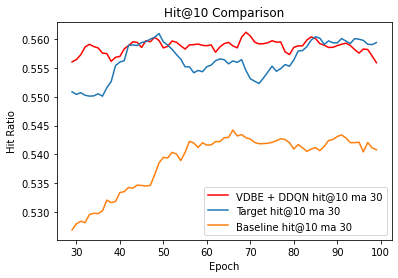

In [35]:
# plt.plot(res, label='hit@10')
plt.plot(pd.Series(res).rolling(30).mean(), c='r', label='VDBE + DDQN hit@10 ma 30')
plt.plot(pd.Series(target100).rolling(30).mean(), label='Target hit@10 ma 30')
plt.plot(pd.Series(baseline100).rolling(30).mean(), label='Baseline hit@10 ma 30')

plt.xlabel('Epoch')
plt.ylabel('Hit Ratio')
plt.title('Hit@10 Comparison')
# plt.ylim([0.4, 0.6])
plt.legend()

In [31]:
with open('../Models/vdbe_100_ddqn.pkl', 'wb') as file_pi:
  pickle.dump(dqn, file_pi, pickle.HIGHEST_PROTOCOL)

In [17]:
'''
請不要關掉這ㄍ分頁 乾蝦哈咪搭
'''

'\n請不要關掉這ㄍ分頁 乾蝦哈咪搭\n'

## Profiling

In [37]:
%load_ext line_profiler
# %reload_ext line_profiler

In [38]:
%%time
exp_replay2 = ReplayBuffer(max_memory=MAX_MEMORY)
epsilon2 = VDBE(0.5, 0.01)

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 13.4 µs


In [39]:
%%time
dqn2 = DQN(exp_replay2, epsilon2, 5, range(2), BATCH_SIZE, LR, SWITCH_PARAM_THRESHOLD)

CPU times: user 8.6 s, sys: 146 ms, total: 8.74 s
Wall time: 8.74 s


### Start Chasing

In [40]:
%lprun -f dqn2.train dqn2.train()

Epoch 0 started.   Time: 15:11:50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0/2 | Loss 30.55317629570345 | Epoch Hit Rate 0.592896174863388 |               Cumulative Hit Rate 0.592896174863388 | Explore 174 | Exploit 192 | Score 315
Epoch 1 started.   Time: 15:12:37


  0%|          | 0/5 [00:00<?, ?it/s]

Timer unit: 1e-09 s

Total time: 60.3371 s
File: <ipython-input-13-35d26399f5ef>
Function: train at line 102

Line #      Hits         Time  Per Hit   % Time  Line Contents
   102                                             def train(self):
   103         1    1439657.0 1439657.0      0.0      self.eval_net.to(DEVICE)
   104         1     502707.0 502707.0      0.0      self.target_net.to(DEVICE)
   105         1        983.0    983.0      0.0      self.c_win_cnt = 0
   106         1      43602.0  43602.0      0.0      self.eval_net.train(True)
   107         1       3875.0   3875.0      0.0      self.epsilon.clear()
   108         1        468.0    468.0      0.0      self.explore = 0
   109         1        306.0    306.0      0.0      self.exploit = 0
   110                                           
   111         2       1601.0    800.5      0.0      for e in self.epochs:
   112         2        842.0    421.0      0.0        self.rec_cnt = 0
   113         2        427.0    213.5

Epoch: 1/2 | Loss 15.90636516964878 | Epoch Hit Rate 0.5 |               Cumulative Hit Rate 0.5702479338842975 | Explore 236 | Exploit 248 | Score 99


### old profiling

In [41]:
%lprun -f exp_replay2.get_batch exp_replay2.get_batch(dqn2.eval_net, dqn2.target_net, batch_size=2)

Timer unit: 1e-09 s

Total time: 0.0665795 s
File: <ipython-input-35-467d7b91a616>
Function: get_batch at line 26

Line #      Hits         Time  Per Hit   % Time  Line Contents
    26                                             def get_batch(self, eval_net, target_net, batch_size=10):
    27                                               # How many experiences do we have?
    28         1       1060.0   1060.0      0.0      len_memory = len(self.memory)
    29                                           
    30                                               # Calculate the number of actions that can possibly be taken in the game.
    31                                               # Actions: 0 = not recommend, 1 = recommend
    32         1        316.0    316.0      0.0      num_actions = self.model_output_shape
    33                                           
    34                                               # Dimensions of our observed states, ie, the input to our model.
    35   

In [42]:
%lprun -f get_input_tensor get_input_tensor(CONTEXT_REPS.iloc[0], CONTEXT_REPS.iloc[0].name[1], with_tensor=True)

Timer unit: 1e-09 s

Total time: 0.0143567 s
File: <ipython-input-8-0d98a1c59d51>
Function: get_input_tensor at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def get_input_tensor(input_state, current_stream, with_tensor=False):
    10                                             # Get item feats
    11                                             # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
    12         1       2209.0   2209.0      0.0    item_list = STREAM_ITEM_DICT[current_stream]
    13         1    2067577.0 2067577.0     14.4    item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})
    14                                           
    15                                             # Fill in other context
    16         1   10489675.0 10489675.0     73.1    stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
    17                                 

### Cleansing
Original Version:
```python
'''
METHOD FOR BOTH EXP_REPLAY & DQN

Convert state format to model input format
'''
def get_input(input_state, current_stream):
  # Get item feats
  # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list]

  # Create new df
  stream_item_feat = pd.DataFrame(columns=INPUT_DF_COL)

  # Fill in other context
  stream_item_feat = stream_item_feat.append([input_state]*len(item_list),ignore_index=True)
  
  # stream_item_feat
  stream_item_feat[LB_ITEMS] = item_feat.reset_index()
  
  return stream_item_feat.astype('float32')
```

In [25]:
%load_ext heat

In [69]:
'''
METHOD FOR BOTH EXP_REPLAY & DQN
Convert state format to model input format

LB_ITEMS = ['item_id'] + [f'i{x}' for x in range(160)]
INPUT_DF_COL__USR = CONTEXT_REPS.columns.to_list()
INPUT_DF_COL = INPUT_DF_COL__USR + LB_ITEMS
'''
input_state = CONTEXT_REPS.iloc[0]
current_stream = CONTEXT_REPS.iloc[0].name[1]
def new_get_input(input_state, current_stream):
  # Get item feats
  # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list]
  
  input_state = pd.DataFrame(input_state).transpose()
  # input_state['item_feat'] = item_feat
  # input_state = input_state.explode('item_feat')
  
  return item_feat

In [70]:
new_get_input(CONTEXT_REPS.iloc[0], CONTEXT_REPS.iloc[0].name[1])

['i0',
 'i1',
 'i2',
 'i3',
 'i4',
 'i5',
 'i6',
 'i7',
 'i8',
 'i9',
 'i10',
 'i11',
 'i12',
 'i13',
 'i14',
 'i15',
 'i16',
 'i17',
 'i18',
 'i19',
 'i20',
 'i21',
 'i22',
 'i23',
 'i24',
 'i25',
 'i26',
 'i27',
 'i28',
 'i29',
 'i30',
 'i31',
 'i32',
 'i33',
 'i34',
 'i35',
 'i36',
 'i37',
 'i38',
 'i39',
 'i40',
 'i41',
 'i42',
 'i43',
 'i44',
 'i45',
 'i46',
 'i47',
 'i48',
 'i49',
 'i50',
 'i51',
 'i52',
 'i53',
 'i54',
 'i55',
 'i56',
 'i57',
 'i58',
 'i59',
 'i60',
 'i61',
 'i62',
 'i63',
 'i64',
 'i65',
 'i66',
 'i67',
 'i68',
 'i69',
 'i70',
 'i71',
 'i72',
 'i73',
 'i74',
 'i75',
 'i76',
 'i77',
 'i78',
 'i79',
 'i80',
 'i81',
 'i82',
 'i83',
 'i84',
 'i85',
 'i86',
 'i87',
 'i88',
 'i89',
 'i90',
 'i91',
 'i92',
 'i93',
 'i94',
 'i95',
 'i96',
 'i97',
 'i98',
 'i99',
 'i100',
 'i101',
 'i102',
 'i103',
 'i104',
 'i105',
 'i106',
 'i107',
 'i108',
 'i109',
 'i110',
 'i111',
 'i112',
 'i113',
 'i114',
 'i115',
 'i116',
 'i117',
 'i118',
 'i119',
 'i120',
 'i121',
 'i122',
 'i

In [49]:
%lprun -f new_get_input new_get_input(CONTEXT_REPS.iloc[0], CONTEXT_REPS.iloc[0].name[1])

Timer unit: 1e-09 s

Total time: 0.00342255 s
File: <ipython-input-48-354800ee8d82>
Function: new_get_input at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                           def new_get_input(input_state, current_stream):
    12                                             # Get item feats
    13                                             # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
    14         1       2660.0   2660.0      0.1    item_list = STREAM_ITEM_DICT[current_stream]
    15         1     552753.0 552753.0     16.2    item_feat = BERT_BY_IDX_DF.loc[item_list]
    16                                             
    17         1    1456739.0 1456739.0     42.6    input_state['item_feat'] = list(item_feat)
    18         1    1410208.0 1410208.0     41.2    input_state = input_state.explode('item_feat')
    19                                             
    20         1        190.0    190.0      0.0    return input_state

In [39]:
def get_input_v2(input_state, current_stream):
  # Get item feats
  item_list = STREAM_ITEM_DICT[current_stream]
  item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})

  # Fill in other context
  stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
  
  # Merge with items
  stream_item_feat = stream_item_feat.merge(item_feat, left_index=True, right_index=True).astype('float32')
  return stream_item_feat

In [85]:
%lprun -f get_input_v2 get_input_v2(CONTEXT_REPS.iloc[0], CONTEXT_REPS.iloc[0].name[1])

Timer unit: 1e-09 s

Total time: 0.0176343 s
File: <ipython-input-84-4d017c41242b>
Function: get_input_v2 at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def get_input_v2(input_state, current_stream):
    10                                             # Get item feats
    11                                             # STREAM_ITEM_DICT: 要拿到對的 STREAM!!!
    12         1       8785.0   8785.0      0.0    item_list = STREAM_ITEM_DICT[current_stream]
    13         1    5560119.0 5560119.0     31.5    item_feat = BERT_BY_IDX_DF.loc[item_list].reset_index().rename(columns={'index': 'item_id'})
    14                                           
    15                                             # Fill in other context
    16         1   10882756.0 10882756.0     61.7    stream_item_feat = pd.DataFrame([input_state]*len(item_list)).reset_index(drop=True)
    17                                             
    18       

### Chasing 2

In [88]:
%%time
baseline_model3 = Baseline()

CPU times: user 115 µs, sys: 2.91 ms, total: 3.02 ms
Wall time: 2.34 ms


In [89]:
%%time
exp_replay3 = ReplayBuffer(max_memory=MAX_MEMORY)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [90]:
%%time
dqn3 = DQN(baseline_model3, exp_replay3, 5, EPOCH, BATCH_SIZE, LR)

CPU times: user 8.32 s, sys: 177 ms, total: 8.5 s
Wall time: 8.49 s


### Start Chasing

In [91]:
%lprun -f dqn3.train dqn3.train()

Epoch 0 started.   Time: 15:23:38


  0%|          | 0/5 [00:00<?, ?it/s]

Timer unit: 1e-09 s

Total time: 3.32292 s
File: <ipython-input-87-1e430f3ba6d5>
Function: train at line 93

Line #      Hits         Time  Per Hit   % Time  Line Contents
    93                                             def train(self):
    94         1   16194974.0 16194974.0      0.5      self.model.to(DEVICE)
    95         1        950.0    950.0      0.0      self.c_win_cnt = 0
    96         1      40919.0  40919.0      0.0      self.model.train(True)
    97                                           
    98         1        738.0    738.0      0.0      for e in self.epochs:
    99         1        361.0    361.0      0.0        self.rec_cnt = 0
   100         1        335.0    335.0      0.0        self.win_cnt = 0
   101         1        395.0    395.0      0.0        self.loss = 0.
   102         1       1624.0   1624.0      0.0        self.epsilon = 4 / ((e + 1) ** (1 / 2))
   103                                           
   104         1      99669.0  99669.0      0.0    

Epoch: 0/100 | Loss 2.4590116441249847 | Epoch Hit Rate 0.775 | Cumulative Hit Rate 0.775 |              Time 15:23:41


In [92]:
%lprun -f exp_replay3.get_batch exp_replay3.get_batch(baseline_model3, batch_size=2)

Timer unit: 1e-09 s

Total time: 0.0848023 s
File: <ipython-input-86-f9f91d8b7747>
Function: get_batch at line 26

Line #      Hits         Time  Per Hit   % Time  Line Contents
    26                                             def get_batch(self, model, batch_size=10):
    27                                               # How many experiences do we have?
    28         1       1013.0   1013.0      0.0      len_memory = len(self.memory)
    29                                           
    30                                               # Calculate the number of actions that can possibly be taken in the game.
    31                                               # Actions: 0 = not recommend, 1 = recommend
    32         1        741.0    741.0      0.0      num_actions = self.model_output_shape
    33                                           
    34                                               # Dimensions of our observed states, ie, the input to our model.
    35                  

Per hit
* exp/get_input:
  * v1: `49609136.0`
  * v2: `12412833.5`
* train/get_batch:
  * v1: `216278453.8`
  * v2: `78445226.8`

In [66]:
predicts = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
if len(predicts) > 10:
  ind = np.argpartition(predicts, -10)[-10:]
  q_val = predicts[ind].sum()
else:
  q_val = predicts.sum()
q_val

tensor(85)

In [67]:
predicts[ind]

tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13])